In [1]:
import pickle
import collections
from urllib.request import urlopen

import pandas as pd

from data_processing import *
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)
#%matplotlib inline
acc_round_val = 2
f1_round_val = 4
alpha = 0.05

# Set the task
task_name = 'swda'
# Get SwDA metadata and training set
base_url = 'https://raw.github.com/NathanDuran/Switchboard-Corpus/master/swda_data/'
metadata = pickle.load(urlopen(base_url + 'metadata/metadata.pkl'))
text_data = [line.decode('utf-8').rstrip('\r\n') for line in urlopen(base_url + 'train_set.txt')]

c:\python\virtual environments\venv-tf-1.15\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Use Punctuation
Whether to remove punctuation from the input sentences or not.

Show punctuation flag value corresponding to max validation and test accuracy per model.

In [41]:
# Name of the experiment parameter for comparison
exp_param = 'use_punct'

# Load punctuation experiment data
punc_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
punc_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(punc_mean_data.loc[[punc_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(punc_mean_data.loc[[punc_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
punc_data_max = get_max(punc_mean_data, [exp_param])
punc_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
  model_name  use_punct    val_acc  val_acc_std
3   text cnn       True  75.611012     0.253492
Best test accuracy in mean data:
  model_name  use_punct   test_acc  test_acc_std  f1_weighted  f1_weighted_std
5       dcnn       True  72.798016       0.49409      0.70222         0.005578


,model_name,use_punct,val_acc,val_acc_std,use_punct,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,True,74.46,0.23,True,71.53,0.54,0.6857,0.0067
1,text cnn,True,75.61,0.25,True,72.79,0.33,0.7014,0.0038
2,dcnn,True,75.02,0.12,True,72.80,0.49,0.7022,0.0056
3,rcnn,True,74.06,0.45,True,72.00,0.58,0.6829,0.0073
4,lstm,True,75.25,0.18,True,72.34,0.54,0.6927,0.0055
5,gru,True,73.70,0.24,True,71.44,0.90,0.6788,0.0122


Plot accuracy of each model per punctuation flag value.

,model_name,use_punct,val_acc,val_acc_std,model_name,use_punct,val_acc,val_acc_std
0,cnn,True,74.46,0.23,cnn,False,73.49,0.24
1,text cnn,True,75.61,0.25,text cnn,False,74.64,0.16
2,dcnn,True,75.02,0.12,dcnn,False,73.96,0.18
3,rcnn,True,74.06,0.45,rcnn,False,73.37,0.26
4,lstm,True,75.25,0.18,lstm,False,74.34,0.21
5,gru,True,73.70,0.24,gru,False,72.91,0.33


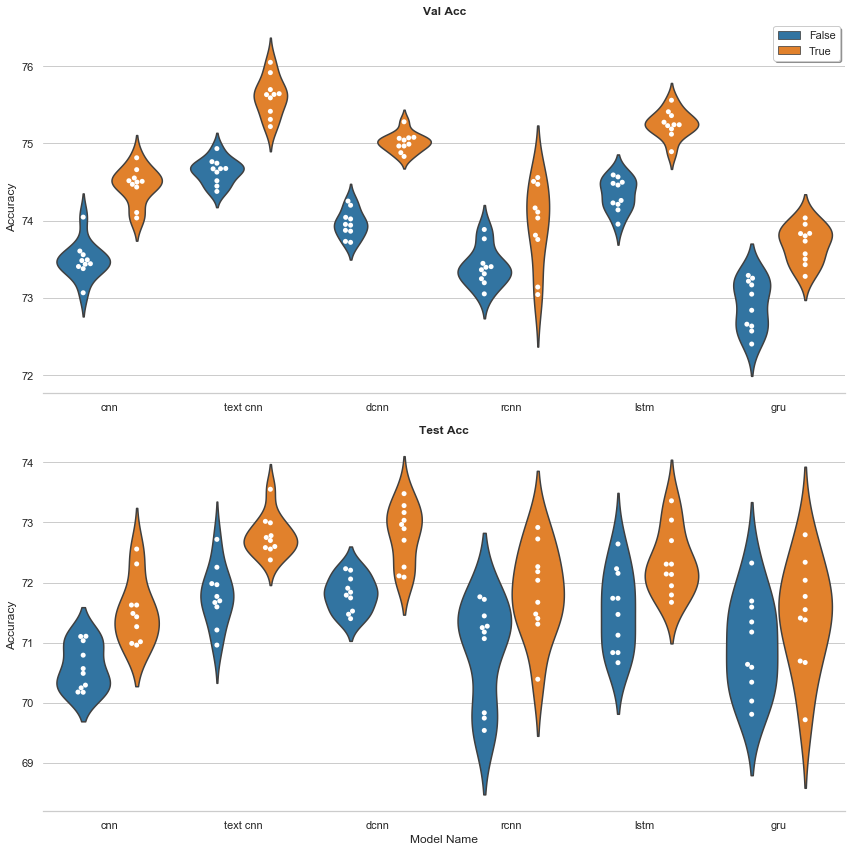

In [3]:
# Get test and validation accuracy for each model
punc_acc_data = punc_data.drop(punc_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
punc_acc_data = punc_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
punc_acc_data = punc_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(punc_acc_data, x="model_name", y="value", hue=exp_param, col='variable', kind='swarm_violin',
                        num_legend_col=1, y_label='Accuracy', x_label='Model Name',
                        share_y=False, num_col=1, dodge=True, colour='default')
g.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

# Get the full validation accuracy/sd for punctuation false and true
punc_mean_data = punc_mean_data.drop(punc_mean_data.columns.difference(['model_name', exp_param, 'val_acc', 'val_acc_std']), axis=1)
punc_true = punc_mean_data[punc_mean_data['use_punct'] == True].reset_index(drop=True)
punc_false = punc_mean_data[punc_mean_data['use_punct'] == False].reset_index(drop=True)
punc_acc_data = pd.concat([punc_true, punc_false], axis=1, ignore_index=False).round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})
punc_acc_data

Perform Wilcoxon signed ranks test comparing punctuation true and false for each model.

In [4]:
# Set the metric to test
metric = 'val_acc'

# Run wilcoxon_rank test
punc_wsr_frame = wilcoxon_rank(punc_data, exp_param, metric, sig_level=alpha)
punc_wsr_frame.round(5)

All models have significant p-values when comparing use_punct groups.


,model_name,t-stat,p-value,cohen-d,exp_n,exp_power,n,power
0,cnn,0.0,0.00506,-4.06682,2.38704,0.8,10.0,1.00000
1,text cnn,0.0,0.00506,-4.55070,2.22681,0.8,10.0,1.00000
2,dcnn,0.0,0.00506,-6.92734,[10.0],0.8,10.0,1.00000
3,rcnn,8.0,0.04685,-1.32512,9.99765,0.8,10.0,0.80010
4,lstm,0.0,0.00506,-4.69085,2.18934,0.8,10.0,1.00000
5,gru,0.0,0.00506,-2.74259,3.37547,0.8,10.0,0.99993


Perform Bayes signed ranks test comparing punctuation true and false for each model.

In [43]:
for model_name in punc_data['model_name'].unique():
    # Get punctuation data to lists
    punc = punc_data.loc[(punc_data['model_name'] == model_name) & (punc_data[exp_param] == True)][metric].tolist()
    no_punc = punc_data.loc[(punc_data['model_name'] == model_name) & (punc_data[exp_param] == False)][metric].tolist()

    # Pair data into 2d array
    data = pair_data(punc, no_punc)

    # Apply Bayesian sign rank
    left, within, right = bt.signrank(data, rope=0.5, verbose=False, names=('punc', 'no_punc'))
    print('Model: {m1} P({c1} > {c2}) = {pl}, P({c2} == {c1}) = {pe}, P({c2} > {c1}) = {pr}'.
          format(m1=model_name, c1='punc', c2='no_punc', pl=left, pe=within, pr=right))

Model: cnn P(punc > no_punc) = 0.99832, P(no_punc == punc) = 0.00168, P(no_punc > punc) = 0.0
Model: text cnn P(punc > no_punc) = 0.9993, P(no_punc == punc) = 0.0007, P(no_punc > punc) = 0.0
Model: dcnn P(punc > no_punc) = 0.99988, P(no_punc == punc) = 0.00012, P(no_punc > punc) = 0.0
Model: rcnn P(punc > no_punc) = 0.75076, P(no_punc == punc) = 0.24916, P(no_punc > punc) = 8e-05
Model: lstm P(punc > no_punc) = 0.99804, P(no_punc == punc) = 0.00196, P(no_punc > punc) = 0.0
Model: gru P(punc > no_punc) = 0.96484, P(no_punc == punc) = 0.03516, P(no_punc > punc) = 0.0


Per-label comparison between punctuation and no-punctuation for the TextCNN model

In [6]:
# Create two empty dataframes
# no_punc_frame = pd.DataFrame(columns=['model', 'label', 'precision' ,'recall' ,'f1-score' , 'support'])
# punc_frame = pd.DataFrame(columns=['model', 'label', 'precision' ,'recall' ,'f1-score' , 'support'])
#
# # Load the per-label scores for each model (punc and no-punc)
# punc_and_lbl_path = os.path.join('raw_data', task_name, 'punct_and_labels')
# for dir_name in os.listdir(punc_and_lbl_path):
#     tmp_frame = pd.read_csv(os.path.join(punc_and_lbl_path, dir_name, dir_name + '_label_metrics.csv'))
#     tmp_frame.insert(0, column='model', value=re.findall(r'\d+', dir_name)[0])
#     tmp_frame.rename( columns={'Unnamed: 0':'label'}, inplace=True )
#
#     # Concat frames
#     if 'no_punc' in dir_name:
#         no_punc_frame = pd.concat([no_punc_frame, tmp_frame])
#     else:
#         punc_frame = pd.concat([punc_frame, tmp_frame])
#
# # Get averaged scores
# no_punc_frame = no_punc_frame.groupby(['label', 'support'], as_index=False).mean()
# no_punc_frame.sort_values('support', ascending=False, inplace=True)
# no_punc_frame.reset_index(drop=True, inplace=True)
#
# punc_frame = punc_frame.groupby(['label', 'support'], as_index=False).mean()
# punc_frame.sort_values('support', ascending=False, inplace=True)
# punc_frame.reset_index(drop=True, inplace=True)
#
# punc_and_lbl_frame = pd.concat([no_punc_frame, punc_frame], keys=['no_punc', 'punc'], axis=1)
# punc_and_lbl_frame.to_csv(os.path.join(task_name, 'punct_and_labels.csv'))
# punc_and_lbl_frame.round(4)

# Letter Case
Whether to lowercase all words from the input sentences or not.

Show lowercase flag value corresponding to max validation and test accuracy per model.

In [44]:
# Name of the experiment parameter for comparison
exp_param = 'to_lower'

# Load punctuation experiment data
case_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
case_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(case_mean_data.loc[[case_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(case_mean_data.loc[[case_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
case_data_max = get_max(case_mean_data, [exp_param])
case_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
  model_name  to_lower    val_acc  val_acc_std
3   text cnn      True  75.333085     0.228255
Best test accuracy in mean data:
  model_name  to_lower  test_acc  test_acc_std  f1_weighted  f1_weighted_std
9       lstm      True   72.7417      0.573446      0.69615         0.006807


,model_name,to_lower,val_acc,val_acc_std,to_lower,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,True,74.73,0.19,False,71.80,0.51,0.6890,0.0067
1,text cnn,True,75.33,0.23,True,72.68,0.37,0.6996,0.0050
2,dcnn,True,74.54,0.19,True,72.33,0.71,0.6945,0.0093
3,rcnn,True,74.46,0.29,True,71.92,0.46,0.6846,0.0061
4,lstm,True,75.24,0.20,True,72.74,0.57,0.6962,0.0068
5,gru,False,74.28,0.40,True,71.83,0.36,0.6841,0.0057


Plot accuracy of each model per lowercase flag value.

,model_name,to_lower,val_acc,val_acc_std,model_name,to_lower,val_acc,val_acc_std
0,cnn,True,74.73,0.19,cnn,False,74.45,0.23
1,text cnn,True,75.33,0.23,text cnn,False,74.77,0.20
2,dcnn,True,74.54,0.19,dcnn,False,74.13,0.20
3,rcnn,True,74.46,0.29,rcnn,False,74.13,0.32
4,lstm,True,75.24,0.20,lstm,False,74.84,0.15
5,gru,True,74.26,0.17,gru,False,74.28,0.40


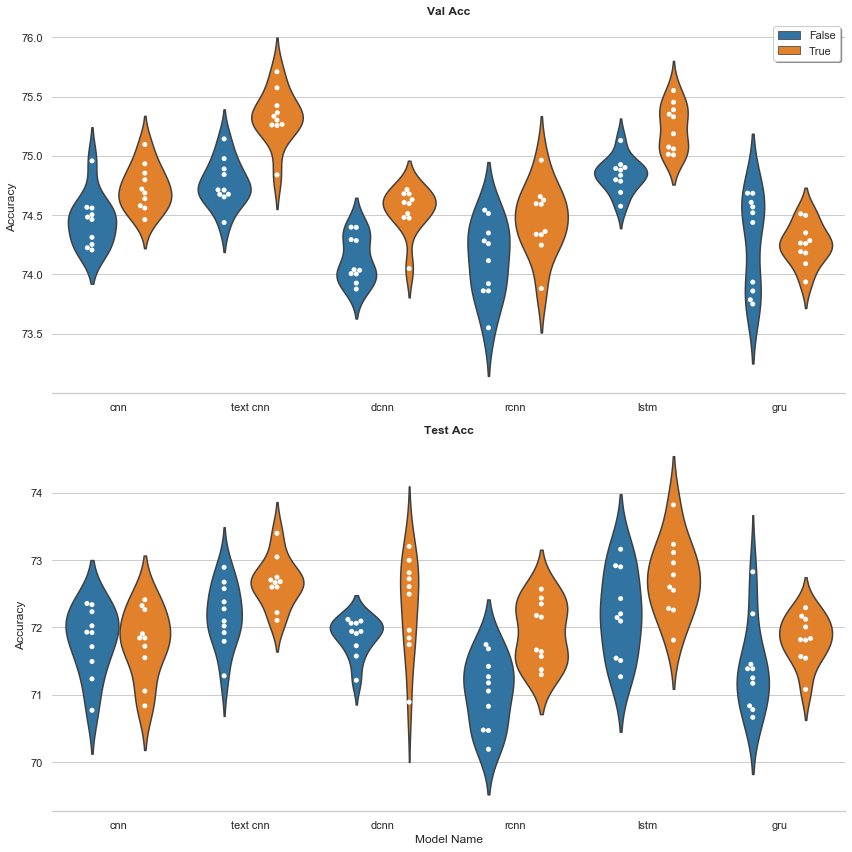

In [8]:
# Get test and validation accuracy for each model
case_acc_data = case_data.drop(case_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
case_acc_data = case_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
case_acc_data = case_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(case_acc_data, x="model_name", y="value", hue=exp_param, col='variable', kind='swarm_violin',
                        num_legend_col=1, y_label='Accuracy', x_label='Model Name',
                        share_y=False, num_col=1, dodge=True, colour='default')
g.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

# Get the full validation accuracy/sd for lowercase false and true
case_mean_data = case_mean_data.drop(case_mean_data.columns.difference(['model_name', exp_param, 'val_acc', 'val_acc_std']), axis=1)
lower_case_true = case_mean_data[case_mean_data['to_lower'] == True].reset_index(drop=True)
lower_case_false = case_mean_data[case_mean_data['to_lower'] == False].reset_index(drop=True)
case_acc_data = pd.concat([lower_case_true, lower_case_false], axis=1, ignore_index=False).round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})
case_acc_data

Perform Wilcoxon signed ranks test comparing lowercase true and false for each model.

In [9]:
# Set the metric to test
metric = 'val_acc'

# Run wilcoxon_rank test
case_wsr_frame = wilcoxon_rank(case_data, exp_param, metric, sig_level=alpha)
case_wsr_frame.round(5)

The following models do not have significant p-values when comparing to_lower groups.
  model_name  t-stat   p-value   cohen-d        exp_n  exp_power     n     power
5        gru    27.0  0.959354  0.087173  2066.675633        0.8  10.0  0.053919


,model_name,t-stat,p-value,cohen-d,exp_n,exp_power,n,power
0,cnn,0.0,0.00506,-1.33995,9.80305,0.8,10.0,0.80873
1,text cnn,0.0,0.00506,-2.63053,3.53969,0.8,10.0,0.99983
2,dcnn,0.0,0.00506,-2.13792,4.62364,0.8,10.0,0.99466
3,rcnn,6.0,0.02842,-1.08472,14.36821,0.8,10.0,0.63114
4,lstm,0.0,0.00506,-2.28803,4.21341,0.8,10.0,0.99794
5,gru,27.0,0.95935,0.08717,2066.67563,0.8,10.0,0.05392


Perform Bayes signed ranks test comparing punctuation true and false for each model.

In [47]:
for model_name in punc_data['model_name'].unique():
    # Get punctuation data to lists
    lower = case_data.loc[(case_data['model_name'] == model_name) & (case_data[exp_param] == True)][metric].tolist()
    mixed = case_data.loc[(case_data['model_name'] == model_name) & (case_data[exp_param] == False)][metric].tolist()

    # Pair data into 2d array
    data = pair_data(lower, mixed)

    # Apply Bayesian sign rank
    left, within, right = bt.signrank(data, rope=0.5, verbose=False, names=('lower', 'mixed'))
    print('Model: {m1} P({c1} > {c2}) = {pl}, P({c2} == {c1}) = {pe}, P({c2} > {c1}) = {pr}'.
          format(m1=model_name, c1='lower', c2='mixed', pl=left, pe=within, pr=right))

Model: cnn P(lower > mixed) = 4e-05, P(mixed == lower) = 0.99996, P(mixed > lower) = 0.0
Model: text cnn P(lower > mixed) = 0.66178, P(mixed == lower) = 0.33822, P(mixed > lower) = 0.0
Model: dcnn P(lower > mixed) = 0.08302, P(mixed == lower) = 0.91698, P(mixed > lower) = 0.0
Model: rcnn P(lower > mixed) = 0.04344, P(mixed == lower) = 0.95656, P(mixed > lower) = 0.0
Model: lstm P(lower > mixed) = 0.05538, P(mixed == lower) = 0.94462, P(mixed > lower) = 0.0
Model: gru P(lower > mixed) = 0.0018, P(mixed == lower) = 0.9982, P(mixed > lower) = 0.0


# Vocabulary Size
The number of words to keep in the vocabulary during pre-processing.
Less frequent words were considered OOV and replaced with the <unk> token. Increments of 500 in the range [500, 8000].

Get the vocabulary size corresponding to max validation and test accuracy per model.

In [10]:
# Name of the experiment parameter for comparison
exp_param = 'vocab_size'

# Load vocabulary experiment data
vocab_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
vocab_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
vocab_data_max = get_max(vocab_mean_data, [exp_param])
vocab_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
   model_name  vocab_size    val_acc  val_acc_std
22   text cnn        5500  75.611698     0.252162
Best test accuracy in mean data:
   model_name  vocab_size   test_acc  test_acc_std  f1_weighted  f1_weighted_std
73       lstm        2500  72.904949       0.46696     0.698919         0.005982


,model_name,vocab_size,val_acc,val_acc_std,vocab_size,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,2500,74.50,0.24,7500,71.85,0.63,0.6878,0.0073
1,text cnn,5500,75.61,0.25,2500,72.85,0.36,0.7024,0.0040
2,dcnn,7500,75.15,0.13,8000,72.70,0.61,0.6978,0.0086
3,rcnn,7500,74.36,0.49,7000,71.77,0.80,0.6837,0.0108
4,lstm,7000,75.25,0.18,2500,72.90,0.47,0.6989,0.0060
5,gru,8000,73.89,0.36,6500,71.94,0.38,0.6849,0.0065


Plot accuracy of each model per vocabulary size.

Vertical lines are the mean frequency of word occurrence within a given range
i.e. the 500-1000 most frequent words appear, on average, ~159 times.

    vocab_size    mean_freq    cum_sum
0        500.0  3373.836327  1690292.0
1       1000.0   159.123752  1769750.0
2       1500.0    72.768463  1806110.0
3       2000.0    43.662675  1827930.0
4       2500.0    29.966068  1842908.0
5       3000.0    22.500998  1854155.0
6       3500.0    17.395210  1862850.0
7       4000.0    13.984032  1869841.0
8       4500.0    11.471058  1875575.0
9       5000.0     9.558882  1880354.0
10      5500.0     8.233533  1884470.0
11      6000.0     7.107784  1888023.0
12      6500.0     6.123752  1891084.0
13      7000.0     5.465070  1893816.0
14      7500.0     5.000000  1896316.0
15      8000.0     4.164000  1898393.0
Total word count: 1922227
Percentage of words for vocabulary size 2500: 95.87


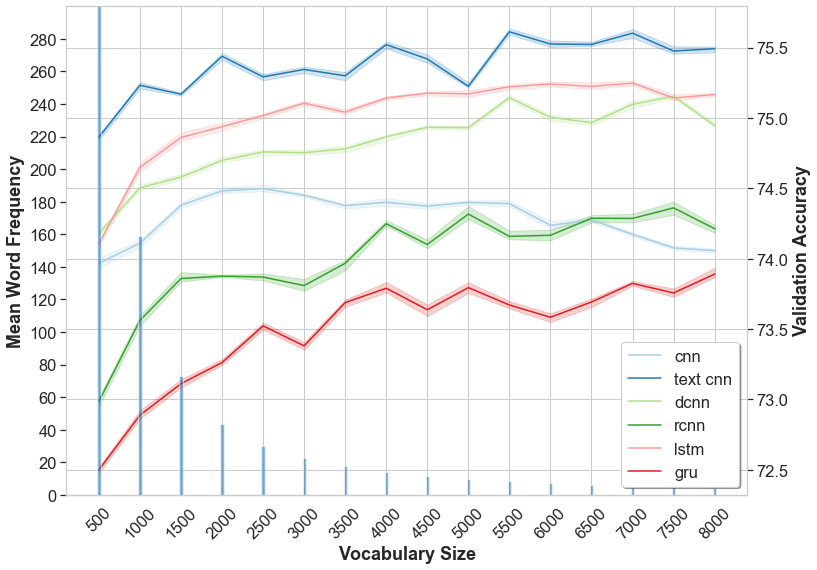

In [11]:
# Get word frequencies from metadata and bin into same values as experiment
word_freq = metadata['word_freq'].iloc[:8000]
words_frame = pd.DataFrame(columns=['vocab_size', 'mean_freq', 'cum_sum'])
ind_start, ind_end = 0, 500
for i in range(16):
    words_frame = words_frame.append({'vocab_size': ind_end,
                                      'mean_freq': float(word_freq.loc[ind_start:ind_end].mean()), # Binning
                                      'cum_sum': word_freq.loc[0:ind_end].sum()['Count']}, # Cumulative summing
                                     ignore_index=True)
    ind_start += 500
    ind_end += 500
print(words_frame)

# Calculate percentage of words up to specified vocabulary size
vocab_size = 2500
total_words = metadata['word_freq']['Count'].sum()
word_cum_sum = float(words_frame.loc[(words_frame['vocab_size'] == vocab_size)]['cum_sum'])
perc_of_total = (100 / total_words) * word_cum_sum
print("Total word count: " + str(total_words))
print("Percentage of words for vocabulary size " + str(vocab_size) + ": " + str(round(perc_of_total, 2)))

# Get experiment validation accuracy data for each model
vocab_acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
vocab_acc_data = vocab_acc_data.rename(columns={'val_acc': 'Val Acc'})
vocab_acc_data = vocab_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(vocab_acc_data, words_frame, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Validation Accuracy', x_label='Vocabulary Size', colour='Paired',
                          bar_x=exp_param, bar_y='mean_freq', bar_axis_step=20, bar_axis_range=[0, 300], bar_width=40,
                          bar_y_label='Mean Word Frequency', bar_alpha=0.5, bar_color='tab:blue',
                          legend_loc='lower right', num_legend_col=1, xtick_rotation=45)
fig.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

Test RM ANOVA assumptions using Shapiro-Wilks test for normality and Mauchly test for sphericity.

Perform RM ANOVA for each model, comparing different vocabulary size groups.

In [13]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(vocab_data, exp_param, metric)

# Run ANOVA
vocab_aov = rm_one_way_anova_test(vocab_data, exp_param, metric, sig_level=alpha)
vocab_aov.round(5)

The following vocab_size are not normally distributed.
   model_name vocab_size    t-stat   p-value
11        cnn       6000  0.795897  0.012926
23   text cnn       4000  0.825525  0.029552
50       rcnn       1500  0.838141  0.041918
62       rcnn       7500  0.753438  0.003930
76       lstm       6500  0.815660  0.022456
All models have significant p-values when comparing vocab_size groups.


,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher,cohen_f,n,exp_n,power,exp_power
cnn,vocab_size,4.15519,15,0.277013,5.26359,3.39757e-08,0.00116464,0.369023,0.29901,True,6.03257e+06,1,0.499345,160,51.4887,0.999998,0.8
text cnn,vocab_size,5.63625,15,0.37575,5.96934,2.11387e-09,9.59327e-05,0.398771,0.388245,True,4.21014e+07,1,0.57921,160,46.4613,1,0.8
dcnn,vocab_size,9.82208,15,0.654805,16.1366,2.70933e-23,5.76918e-10,0.641956,0.373727,True,1.61421e+08,1,1.4,160,[160.0],1,0.8
rcnn,vocab_size,18.7598,15,1.25066,10.2498,5.50466e-16,1.03772e-06,0.532462,0.340894,True,607455,1,0.970361,160,34.0469,1,0.8
lstm,vocab_size,12.9309,15,0.862063,16.8002,5.10879e-24,2.34682e-09,0.651165,0.333943,True,5.13875e+07,1,1.4,160,[160.0],1,0.8
gru,vocab_size,22.1739,15,1.47826,14.6544,1.3075e-21,7.32057e-10,0.619522,0.40081,True,4.55875e+06,1,1.4,160,[160.0],1,0.8


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

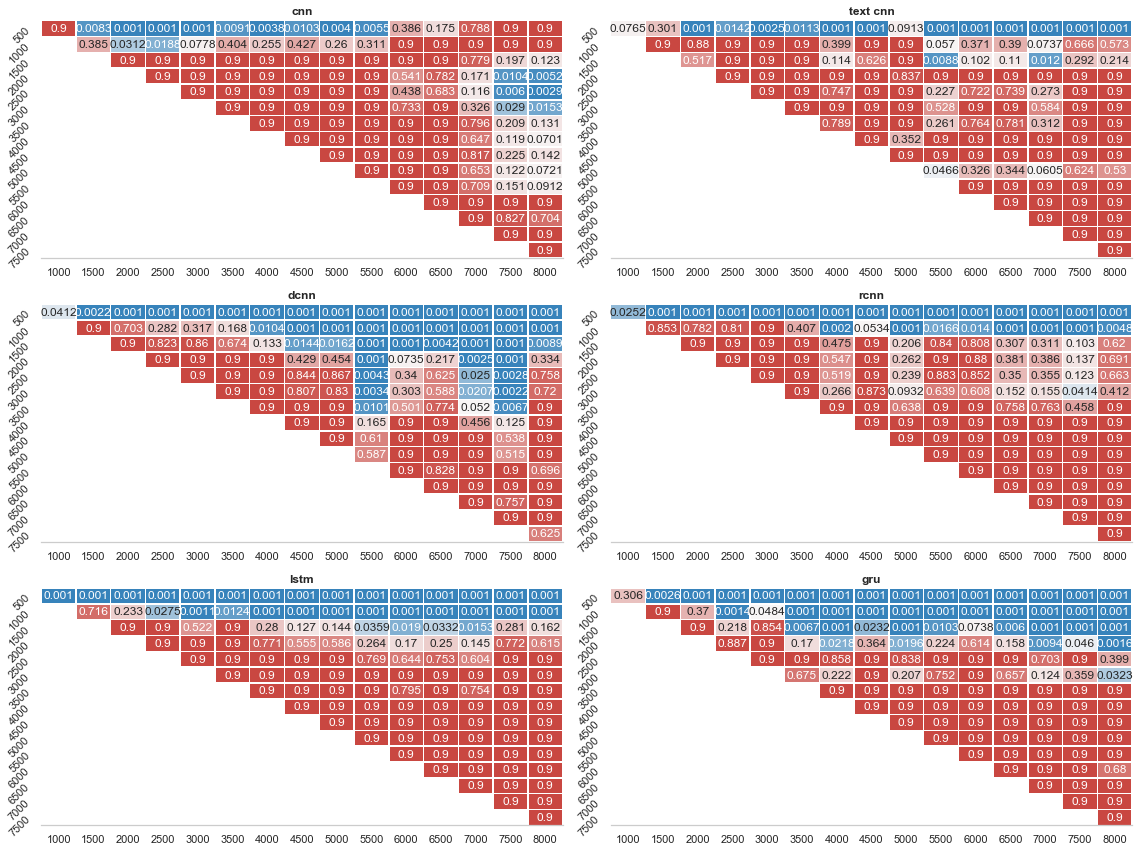

In [14]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(vocab_data, exp_param, metric, sig_level=alpha, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, alpha, 1.0],
                        y_tick_rotation=45, height=4)

Multiple Pairwise Bayes sign rank

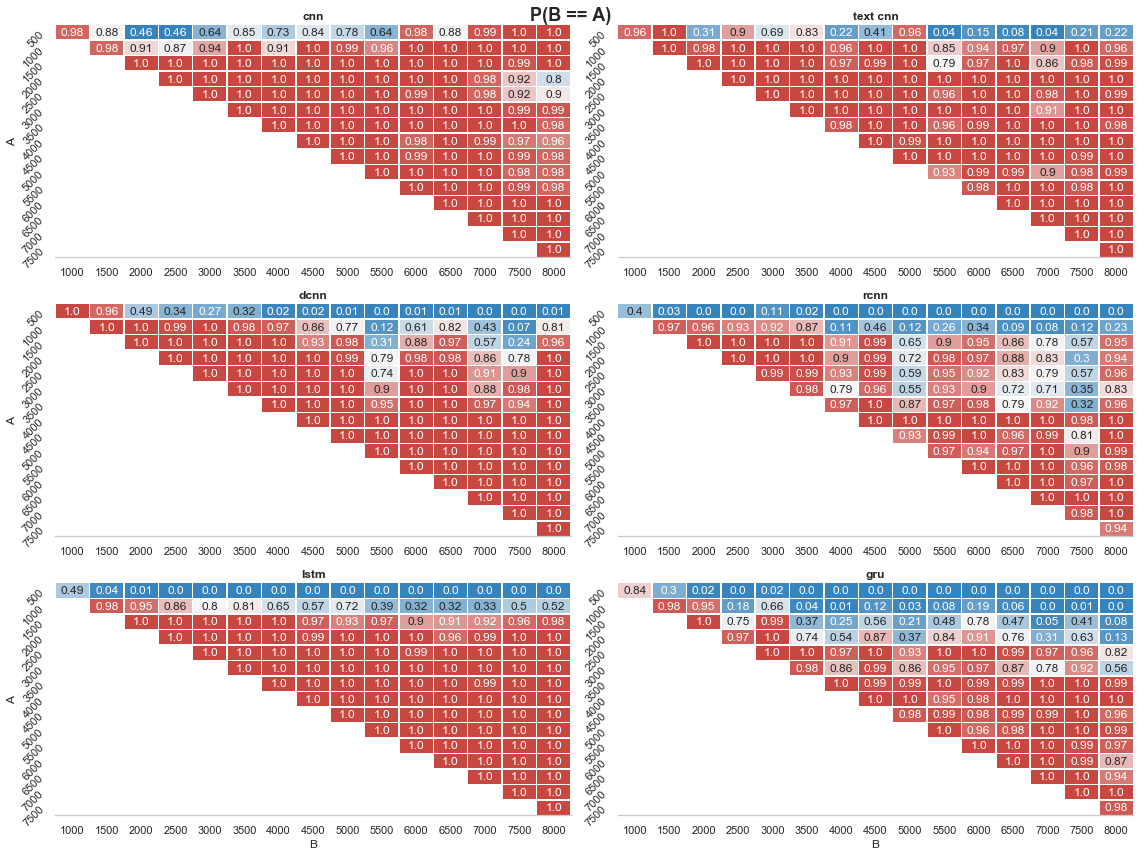

In [8]:
# Set the metric to test
metric = 'val_acc'

# Multi-pairwise Bayes takes a long time to calculate, so save/load as needed
# bayes_vocab_frame = multi_pairwise_bayes_signrank(vocab_data, 'model_name', exp_param, metric, rope=0.5)
# save_dataframe(os.path.join(task_name, exp_param, exp_param + '_bayes_results.csv'), bayes_vocab_frame)
bayes_vocab_frame = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_bayes_results.csv'))

# Generate heatmaps
g, fig = plot_facetgrid(bayes_vocab_frame.round(2), x='model_A', y='model_B', hue='within', col='model_name', kind='heatmap',
                        title='P(B == A)', y_label='A', x_label='B', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.2', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.8, 1.0],
                        y_tick_rotation=45, height=4)
# bayes_vocab_frame.round(3)

# Sequence Length
The number of tokens in the input sequence. Sentences are padded, with a <pad> token, or truncated to this length.
Increments of 5 in the range [5, 50].

Get the sequence length corresponding to max validation and test accuracy per model.

In [12]:
# Name of the experiment parameter for comparison
exp_param = 'max_seq_length'

# Load sequence length experiment data
seq_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
seq_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
seq_data_max = get_max(seq_mean_data, [exp_param])
seq_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
   model_name  max_seq_length    val_acc  val_acc_std
14   text cnn              25  75.633028      0.24392
Best test accuracy in mean data:
   model_name  max_seq_length   test_acc  test_acc_std  f1_weighted  f1_weighted_std
40       lstm              50  72.914715      0.277824     0.698838         0.003376


,model_name,max_seq_length,val_acc,val_acc_std,max_seq_length,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,45,74.43,0.17,35,71.78,0.43,0.6886,0.0048
1,text cnn,25,75.63,0.24,20,72.82,0.28,0.7014,0.0034
2,dcnn,30,75.10,0.23,35,72.68,0.25,0.6997,0.0033
3,rcnn,40,74.50,0.28,50,72.20,0.43,0.6874,0.0056
4,lstm,25,75.35,0.16,50,72.91,0.28,0.6988,0.0034
5,gru,25,73.94,0.27,40,72.11,0.38,0.6882,0.0045


Plot accuracy of each model per sequence length.

Vertical lines are the cumulative frequency of utterances up to a given sequence length
i.e. there are 145129 sentences in the test set of length <= 10.

   max_seq_length     mean_freq   cum_sum
0             5.0  20326.200000  101631.0
1            10.0   8995.666667  145129.0
2            15.0   4959.666667  168097.0
3            20.0   2518.500000  179728.0
4            25.0   1289.333333  185700.0
5            30.0    658.833333  188789.0
6            35.0    353.833333  190424.0
7            40.0    191.833333  191330.0
8            45.0    100.166667  191794.0
9            50.0     52.500000  192048.0
Total sentence count: 192390
Percentage of sentences for sequence length 25: 96.52


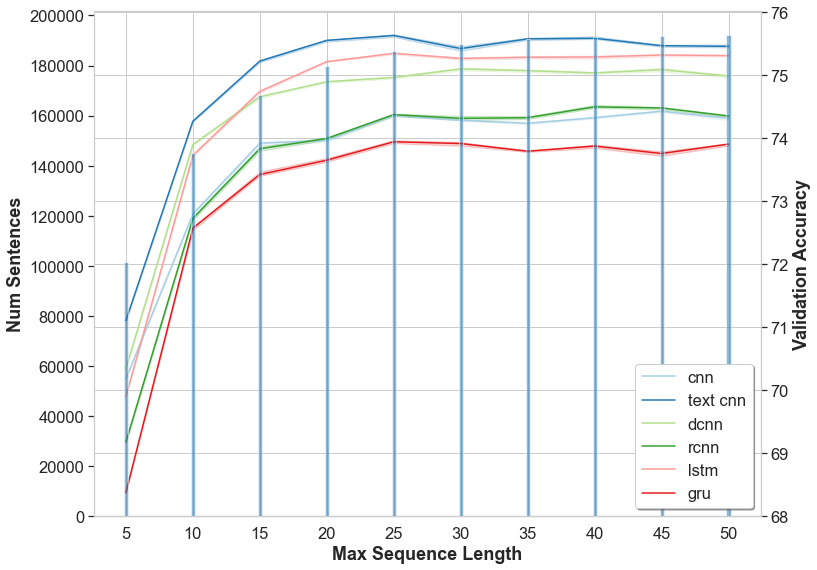

In [17]:
# Get text data from training set and count sequence lengths
sentences = [line.split('|')[1] for line in text_data]
sent_lengths = [len(sent.split(' ')) for sent in sentences]
sent_lengths = collections.Counter(sent_lengths)
sent_lengths = pd.DataFrame.from_dict(dict(sorted(sent_lengths.items())), orient='index')

# Get word sentence lengths and bin/sum into same values as experiment
sents_frame = pd.DataFrame(columns=['max_seq_length', 'mean_freq', 'cum_sum'])
ind_start, ind_end = 0, 5
for i in range(10):
    sents_frame = sents_frame.append({'max_seq_length': ind_end,
                                      'mean_freq': float(sent_lengths.loc[ind_start:ind_end].mean()), # Binning
                                      'cum_sum': float(sent_lengths.loc[0:ind_end].sum())}, # Cumulative summing
                                     ignore_index=True)
    ind_start += 5
    ind_end += 5
print(sents_frame)

# Calculate percentage of sentences up to specified max length
seq_len = 25
total_sent = int(sent_lengths.sum())
sent_cum_sum = float(sents_frame.loc[(sents_frame['max_seq_length'] == seq_len)]['cum_sum'])
perc_of_total = (100 / total_sent) * sent_cum_sum
print("Total sentence count: " + str(total_sent))
print("Percentage of sentences for sequence length " + str(seq_len) + ": " + str(round(perc_of_total, 2)))

# Get experiment validation accuracy data for each model
seq_acc_data = seq_data.drop(seq_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
seq_acc_data = seq_acc_data.rename(columns={'val_acc': 'Val Acc'})
seq_acc_data = seq_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(seq_acc_data, sents_frame, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Validation Accuracy', x_label='Max Sequence Length', colour='Paired',
                          bar_x=exp_param, bar_y='cum_sum', bar_axis_step=20000, bar_axis_range=None, bar_width=0.3,
                          bar_y_label='Num Sentences', bar_alpha=0.5, bar_color='tab:blue',
                          legend_loc='lower right', num_legend_col=1)
fig.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

Test RM ANOVA assumptions using Shapiro-Wilks test for normality and Mauchly test for sphericity.

Perform RM ANOVA for each model, comparing different sequence length groups.

In [18]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(seq_data, exp_param, metric)

# Run ANOVA
seq_aov = rm_one_way_anova_test(seq_data, exp_param, metric, sig_level=alpha)
seq_aov.round(5)

The following max_seq_length are not normally distributed.
   model_name max_seq_length    t-stat   p-value
4         cnn             25  0.779160  0.008086
17   text cnn             40  0.817419  0.023584
51        gru             10  0.819752  0.025168
All models have significant p-values when comparing max_seq_length groups.


,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher,cohen_f,n,exp_n,power,exp_power
cnn,max_seq_length,156.994,9,17.4438,409.587,1.18718e-63,5.02601e-38,0.978499,0.583248,True,0.412622,1,1.4,100,21.2739,1,0.8
text cnn,max_seq_length,177.002,9,19.6669,359.369,2.07938e-61,4.47141e-31,0.975568,0.488231,True,0.161441,1,1.4,100,21.2739,1,0.8
dcnn,max_seq_length,194.944,9,21.6604,484.55,1.5201e-66,2.59878e-34,0.981765,0.499493,True,0.386174,1,1.4,100,21.2739,1,0.8
rcnn,max_seq_length,243.303,9,27.0336,379.781,2.35107e-62,4.14603e-25,0.976851,0.381756,True,0.0304796,1.00023,1.4,100,21.2739,1,0.8
lstm,max_seq_length,262.224,9,29.136,716.676,2.57326e-73,7.89355e-38,0.987598,0.501372,True,0.402127,1,1.4,100,21.2739,1,0.8
gru,max_seq_length,265.611,9,29.5123,322.116,1.54536e-59,2.4182e-32,0.972819,0.526158,True,0.0029167,0.979825,1.4,100,21.2739,1,0.8


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

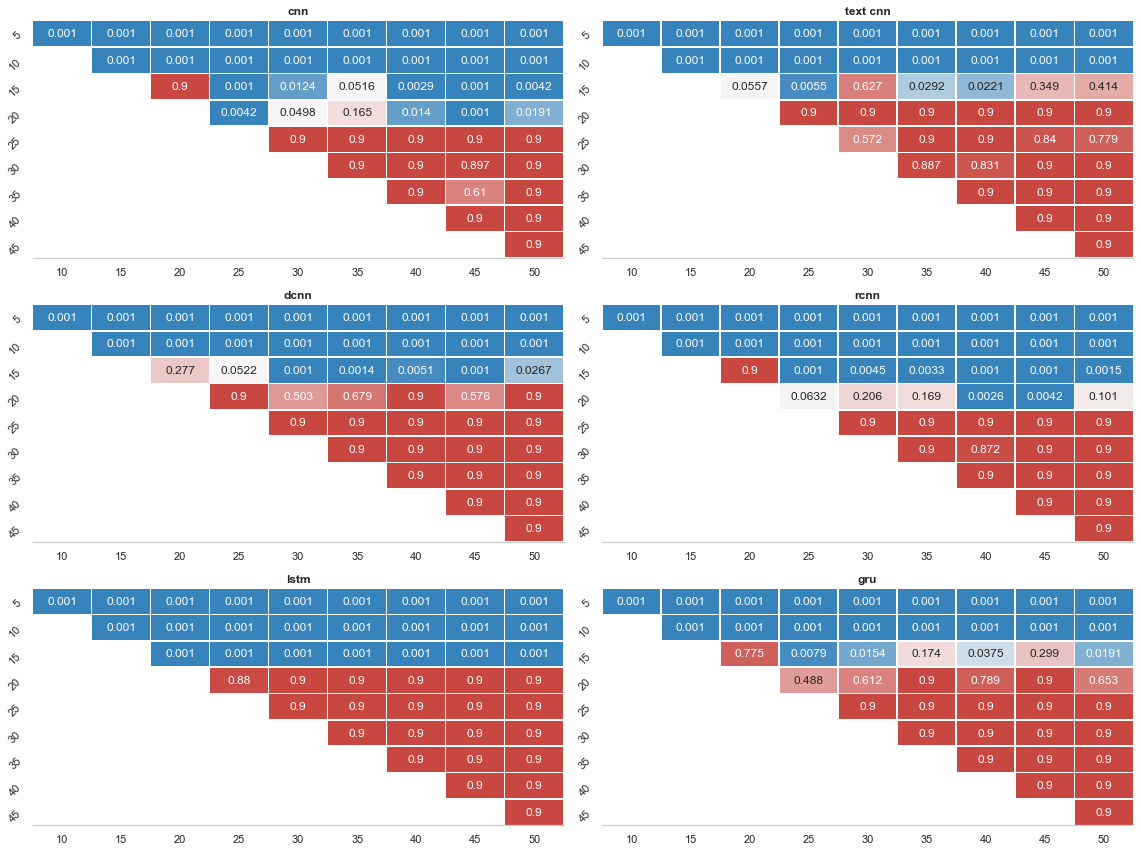

In [19]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(seq_data, exp_param, metric, sig_level=alpha, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, alpha, 1.0],
                        y_tick_rotation=45, height=4)

Multiple Pairwise Bayes sign rank

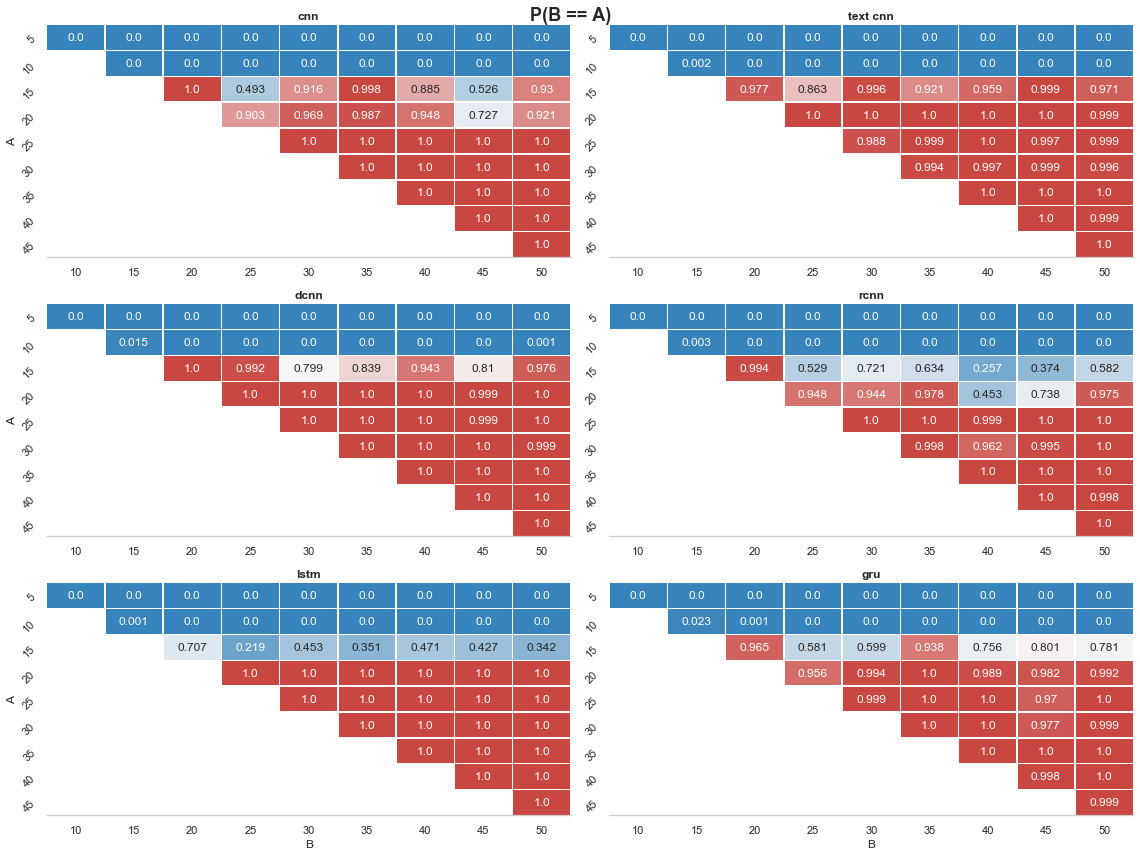

In [17]:
# Set the metric to test
metric = 'val_acc'

# Multi-pairwise Bayes takes a long time to calculate, so save/load as needed
# bayes_seq_frame = multi_pairwise_bayes_signrank(seq_data, 'model_name', exp_param, metric, rope=0.5)
# save_dataframe(os.path.join(task_name, exp_param, exp_param + '_bayes_results.csv'), bayes_seq_frame)
bayes_seq_frame = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_bayes_results.csv'))

# Generate heatmaps
g, fig = plot_facetgrid(bayes_seq_frame.round(3), x='model_A', y='model_B', hue='within', col='model_name', kind='heatmap',
                        title='P(B == A)', y_label='A', x_label='B', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.8, 1.0],
                        y_tick_rotation=45, height=4)
# bayes_seq_frame.round(3)

# Input Sequence Comparison

Compare a combination of vocabulary sizes (2.5k, 5k or 10k words) and sequence lengths (25, 50 or 128 tokens)
in small, medium and large groups.

In [18]:
# Name of the experiment parameters for comparison
exp_params = ['vocab_size', 'max_seq_length']
# Load experiment data
inseq_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_data.csv'))
inseq_mean_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
inseq_data_max = get_max(inseq_mean_data, exp_params)
inseq_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
  model_name  vocab_size  max_seq_length    val_acc  val_acc_std
3   text cnn        2500              25  75.408256      0.08534
Best test accuracy in mean data:
   model_name  vocab_size  max_seq_length   test_acc  test_acc_std  f1_weighted  f1_weighted_std
14       lstm       10000             128  72.901694      0.499982     0.698698          0.00682


,model_name,vocab_size,max_seq_length,val_acc,val_acc_std,vocab_size,max_seq_length,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,5000,50,74.86,0.24,10000,128,71.87,0.45,0.6899,0.0048
1,text cnn,2500,25,75.41,0.09,10000,128,72.63,0.63,0.6973,0.0086
2,dcnn,5000,50,74.68,0.24,10000,128,72.38,0.48,0.6940,0.0072
3,rcnn,10000,128,74.51,0.17,10000,128,71.90,0.52,0.6851,0.0066
4,lstm,10000,128,75.35,0.15,10000,128,72.90,0.50,0.6987,0.0068
5,gru,5000,50,74.37,0.17,10000,128,71.88,0.63,0.6837,0.0098


Test RM ANOVA assumptions using Shapiro-Wilks test for normality and Mauchly test for sphericity.

Perform RM ANOVA comparing vocabulary size (2.5k, 5k or 10k words) and sequence lengths (25, 50 or 128 tokens) for each model.

In [30]:
# Add column to identify each combination
inseq_data = inseq_data.drop(inseq_data.columns.difference(['model_name', 'val_acc', 'vocab_size', 'max_seq_length']), axis=1)
conditions = [(inseq_data['vocab_size'] == 2500) & (inseq_data['max_seq_length'] == 25),
              (inseq_data['vocab_size'] == 5000) & (inseq_data['max_seq_length'] == 50),
              (inseq_data['vocab_size'] == 10000) & (inseq_data['max_seq_length'] == 128)]
choices = ['V=2.5k_S=25', 'V=5k_S=50', 'V=10k_S=128']
inseq_data['exp_params'] = np.select(conditions, choices)
inseq_data.drop(inseq_data[inseq_data.exp_params == '0'].index, inplace=True)

# Set the metric to test and new exp_param column
metric = 'val_acc'
exp_param = 'exp_params'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(inseq_data, exp_param, metric)

# Run ANOVA
seq_aov = rm_one_way_anova_test(inseq_data, exp_param, metric, sig_level=alpha)
seq_aov.round(5)

The following exp_params are not normally distributed.
  model_name   exp_params    t-stat   p-value
9       rcnn  V=2.5k_S=25  0.826745  0.030571
The following models do not have significant p-values when comparing exp_params groups.
              Source         SS DF         MS         F     p-unc p-GG-corr        np2       eps sphericity   W-spher    p-spher    cohen_f   n    exp_n     power exp_power
cnn       exp_params   0.119722  2  0.0598612   1.39077   0.27438  0.273793   0.133847  0.674376       True  0.517148  0.0715252  0.0634443  30  154.896   0.19753       0.8
text cnn  exp_params  0.0684488  2  0.0342244  0.797296  0.465829  0.428361  0.0813792  0.690043       True  0.550814  0.0920492  0.0559254  30  175.308   0.17861       0.8
dcnn      exp_params  0.0725051  2  0.0362526   0.72006  0.500221  0.481521  0.0740798  0.854167       True  0.829269   0.472913  0.0459688  30  212.616  0.153952       0.8
rcnn      exp_params   0.345804  2   0.172902   2.28055  0.130981  0.1492

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher,cohen_f,n,exp_n,power,exp_power
cnn,exp_params,0.119722,2,0.0598612,1.39077,0.27438,0.273793,0.133847,0.674376,True,0.517148,0.0715252,0.0634443,30,154.896,0.19753,0.8
text cnn,exp_params,0.0684488,2,0.0342244,0.797296,0.465829,0.428361,0.0813792,0.690043,True,0.550814,0.0920492,0.0559254,30,175.308,0.17861,0.8
dcnn,exp_params,0.0725051,2,0.0362526,0.72006,0.500221,0.481521,0.0740798,0.854167,True,0.829269,0.472913,0.0459688,30,212.616,0.153952,0.8
rcnn,exp_params,0.345804,2,0.172902,2.28055,0.130981,0.149237,0.202167,0.732728,True,0.635236,0.162833,0.144508,30,69.7565,0.404296,0.8
lstm,exp_params,0.223753,2,0.111876,2.51061,0.109219,0.12728,0.218112,0.753556,True,0.672958,0.205094,0.187237,30,54.5672,0.505654,0.8
gru,exp_params,0.279268,2,0.139634,2.22869,0.136528,0.147664,0.198481,0.830946,True,0.796552,0.402583,0.145959,30,69.095,0.407875,0.8


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

,model_name,vocab_size,max_seq_length,val_acc,val_acc_std
0,cnn,2500,25,74.743838,0.204731
1,cnn,5000,50,74.858151,0.235315
2,cnn,10000,128,74.710674,0.302352
3,text cnn,2500,25,75.408256,0.085340
4,text cnn,5000,50,75.294693,0.294185
5,text cnn,10000,128,75.327086,0.169013
6,dcnn,5000,50,74.677440,0.243719
7,dcnn,2500,25,74.557039,0.175786
8,dcnn,10000,128,74.619072,0.259667
9,rcnn,2500,25,74.249954,0.375296


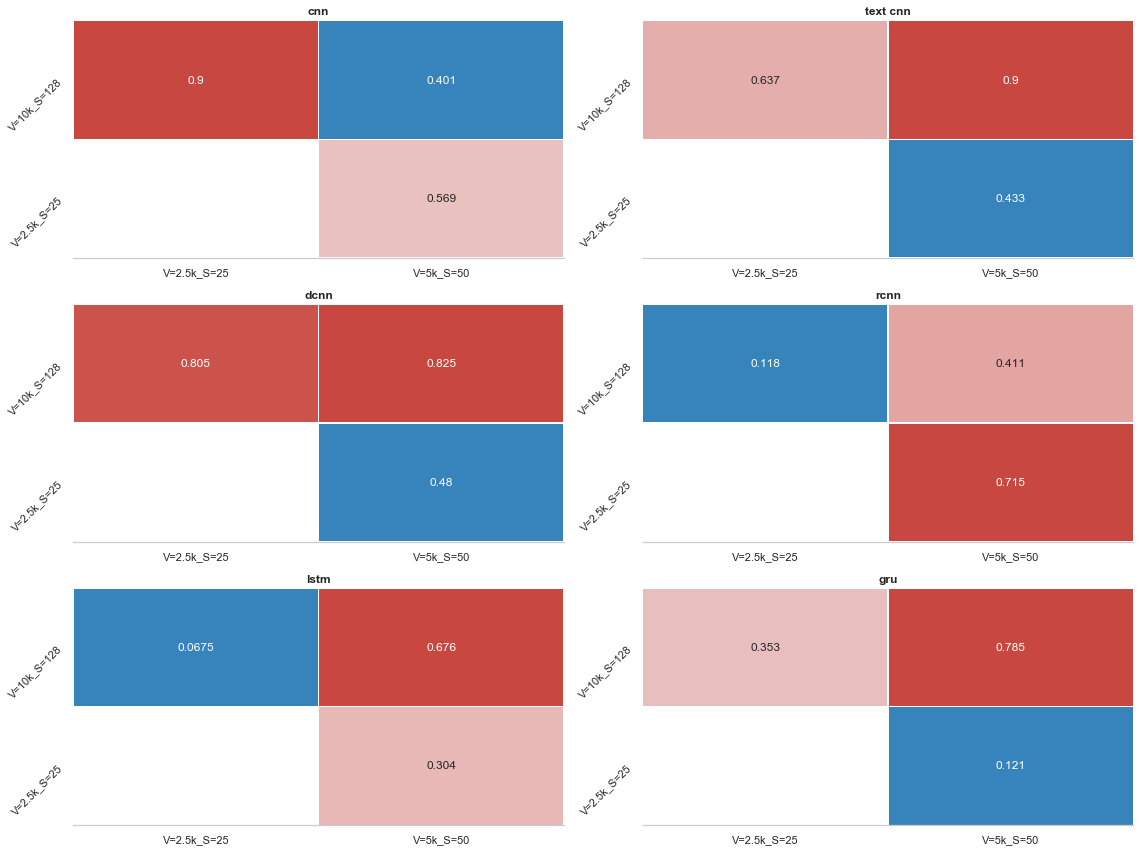

In [23]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(inseq_data, exp_param, metric, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, alpha, 1.0],
                        y_tick_rotation=45, height=4)

# Show results for each group
inseq_mean_data = inseq_mean_data.drop(inseq_mean_data.columns.difference(['model_name', 'val_acc', 'val_acc_std', 'vocab_size', 'max_seq_length']), axis=1)
inseq_mean_data

Pairwise Bayes sign rank

,model_name,model_A,model_B,P({a} > {b}),P({a} == {b}),P({b} > {a}),left,within,right
0,cnn,25,50,0.0,1.000,0.000,0.0,1.000,0.000
1,cnn,25,128,0.0,1.000,0.000,0.0,1.000,0.000
2,cnn,50,128,0.0,1.000,0.000,0.0,1.000,0.000
3,text cnn,25,50,0.0,1.000,0.000,0.0,1.000,0.000
4,text cnn,25,128,0.0,1.000,0.000,0.0,1.000,0.000
5,text cnn,50,128,0.0,1.000,0.000,0.0,1.000,0.000
6,dcnn,25,50,0.0,1.000,0.000,0.0,1.000,0.000
7,dcnn,25,128,0.0,1.000,0.000,0.0,1.000,0.000
8,dcnn,50,128,0.0,1.000,0.000,0.0,1.000,0.000
9,rcnn,25,50,0.0,0.998,0.002,0.0,0.998,0.002


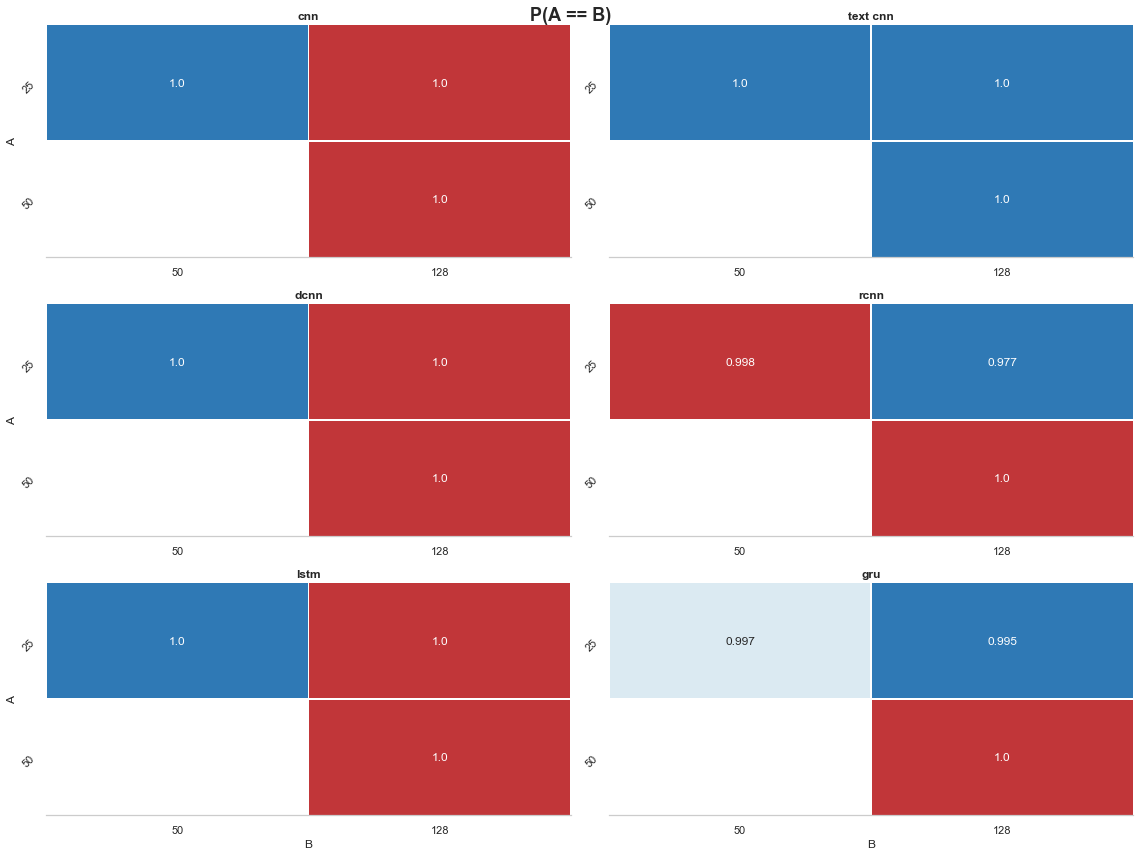

In [19]:
# Set the metric to test
metric = 'val_acc'

# Multi-pairwise Bayes
inseq_bayes = multi_pairwise_bayes_signrank(inseq_data, 'model_name', exp_param, metric, rope=0.5)

# Generate heatmaps
g, fig = plot_facetgrid(inseq_bayes, x='model_A', y='model_B', hue='within', col='model_name', kind='heatmap',
                        title='P(A == B)', y_label='A', x_label='B', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False,
                        y_tick_rotation=45, height=4)
inseq_bayes.round(3)

# Word Vectors

Compare different dimensions of Word2Vec, GloVe, Fasttext, Numberbatch and Dependency for each model.
Dimension increments of 50 in the range [100, 300].

Get the embedding type and dimension corresponding to max validation and test accuracy per model.

In [53]:
# Name of the experiment parameter for comparison
exp_params = ['embedding_type', 'embedding_dim']

# Load language models experiment data
embed_data = load_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type_data.csv'))
embed_mean_data = load_dataframe(os.path.join(task_name,  'embedding_type', 'embedding_type_mean_data.csv'))

# Remove random embeddings because they are strictly worse
embed_data = embed_data.drop(embed_data[embed_data['embedding_type'] == 'random'].index)
embed_mean_data = embed_mean_data.drop(embed_mean_data[embed_mean_data['embedding_type'] == 'random'].index)

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
embed_data_max = get_max(embed_mean_data, exp_params)
embed_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
   model_name embedding_type  embedding_dim    val_acc  val_acc_std
48   text cnn    numberbatch            300  76.010386      0.12203
Best test accuracy in mean data:
   model_name embedding_type  embedding_dim   test_acc  test_acc_std  f1_weighted  f1_weighted_std
48   text cnn    numberbatch            300  73.663087      0.445725     0.713489         0.005253


,model_name,embedding_type,embedding_dim,val_acc,val_acc_std,embedding_type,embedding_dim,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,numberbatch,100,74.59,0.16,numberbatch,100,71.74,0.44,0.6888,0.0050
1,text cnn,numberbatch,300,76.01,0.12,numberbatch,300,73.66,0.45,0.7135,0.0053
2,dcnn,fasttext,200,75.66,0.15,glove,100,72.97,0.38,0.7031,0.0039
3,rcnn,fasttext,200,75.06,0.27,fasttext,250,72.70,0.60,0.6942,0.0080
4,lstm,glove,300,75.57,0.21,glove,300,73.11,0.50,0.7001,0.0064
5,gru,fasttext,100,74.87,0.28,fasttext,100,72.53,0.51,0.6932,0.0072


Heatmap plot of accuracy of each model per embedding type and dimension.

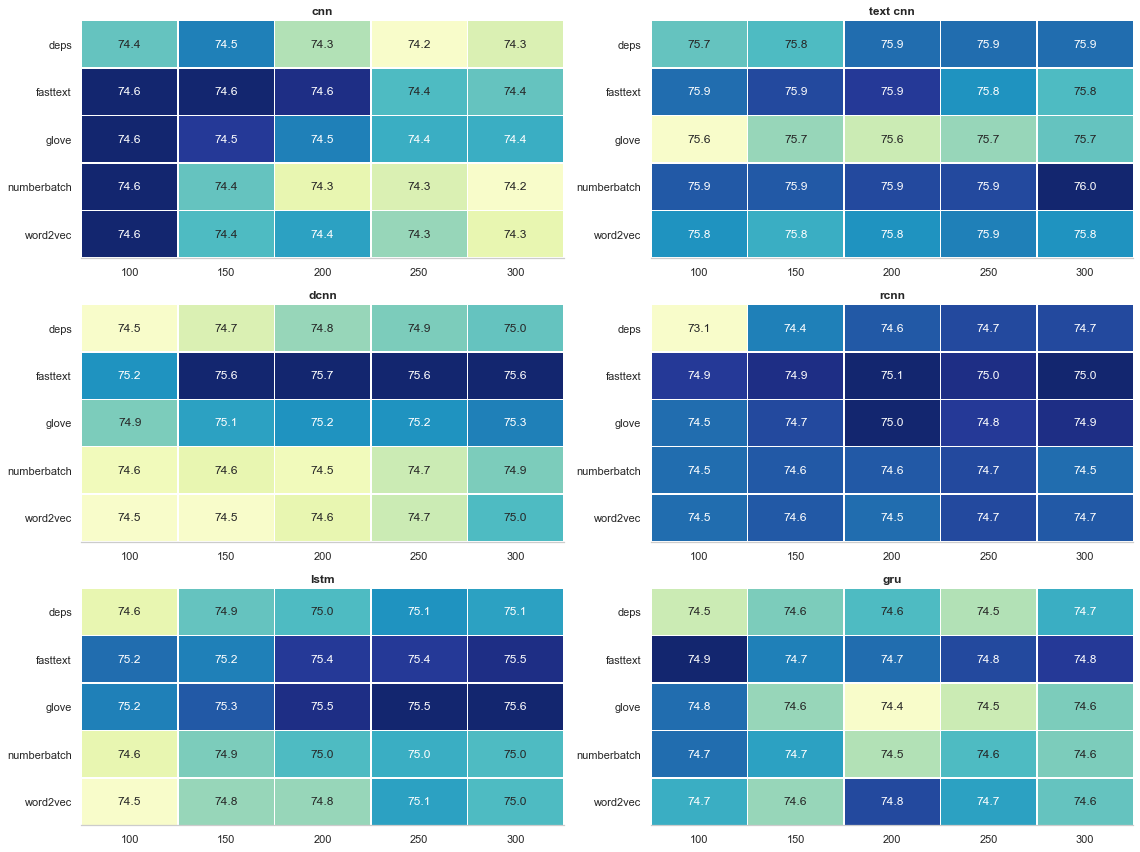

In [26]:
# Get test and validation accuracy for each model
embed_acc_data = embed_mean_data.drop(embed_mean_data.columns.difference(['model_name'] + exp_params + ['val_acc', 'test_acc']), axis=1)

g, fig = plot_facetgrid(embed_acc_data, x='embedding_type', y='embedding_dim', hue='val_acc', col='model_name',
                        kind='heatmap', title='', y_label='', x_label='', num_col=2, colour='YlGnBu', num_colour=20,
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, height=4)
g.savefig(os.path.join(task_name, 'embedding_type', 'embedding_type_accuracy.png'))

Test RM ANOVA assumptions using Shapiro-Wilks test for normality and Mauchly test for sphericity.

Perform Two-way RM ANOVA for each model, comparing different embedding type and dimension groups.

In [27]:
# Set the metric to test
metric = 'val_acc'

# Add embedding type and dimension column
embed_data['embedding_params'] = embed_data.apply(lambda row: row['embedding_type'] + "_" + str(row['embedding_dim']), axis=1)

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(embed_data, 'embedding_params', metric)

# Run Mauchly test for sphericity
mauchly_test(embed_data, 'embedding_params', metric)

# Run Two-way RM ANOVA
embedd_aov = rm_two_way_anova_test(embed_data, exp_params, metric, sig_level=alpha, show_result=True)
embedd_aov.round(5)

The following embedding_params are not normally distributed.
    model_name embedding_params    t-stat       p-value
24         cnn        glove_150  0.798237  1.380062e-02
41    text cnn  numberbatch_250  0.843851  4.906363e-02
49    text cnn     word2vec_150  0.831870  3.524159e-02
58        dcnn  numberbatch_100  0.842730  4.757236e-02
63        dcnn     word2vec_250  0.814990  2.203972e-02
66        dcnn     word2vec_150  0.840200  4.436784e-02
72        dcnn     fasttext_200  0.843929  4.916905e-02
75        rcnn  numberbatch_300  0.650402  2.219227e-04
80        rcnn         deps_300  0.728703  1.964893e-03
81        rcnn         deps_100  0.443029  7.864205e-07
84        rcnn         deps_150  0.794356  1.237940e-02
86        rcnn        glove_100  0.823439  2.788741e-02
87        rcnn     fasttext_100  0.836128  3.964889e-02
98        rcnn        glove_300  0.796981  1.332367e-02
103       lstm     word2vec_150  0.778495  7.936632e-03
104       lstm        glove_250  0.836990  

,model_name,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cnn,embedding_type,1.18259,4,36,0.29565,9.90902,0.00002,0.00033,0.52404,0.65380
1,cnn,embedding_dim,1.95828,4,36,0.48957,15.18828,0.00000,0.00016,0.62792,0.48577
2,cnn,embedding_type * embedding_dim,0.54113,16,144,0.03382,0.76469,0.72279,0.56838,0.07831,0.28151
3,text cnn,embedding_type,2.02142,4,36,0.50535,11.62105,0.00000,0.00009,0.56355,0.68576
4,text cnn,embedding_dim,0.15839,4,36,0.03960,0.68718,0.60555,0.55846,0.07094,0.69825
5,text cnn,embedding_type * embedding_dim,0.54707,16,144,0.03419,0.61796,0.86557,0.66997,0.06425,0.28025
6,dcnn,embedding_type,29.24753,4,36,7.31188,150.34860,0.00000,0.00000,0.94352,0.69464
7,dcnn,embedding_dim,5.84803,4,36,1.46201,40.68759,0.00000,0.00000,0.81887,0.72730
8,dcnn,embedding_type * embedding_dim,1.57980,16,144,0.09874,2.07663,0.01228,0.11422,0.18748,0.22072
9,rcnn,embedding_type,12.26696,4,36,3.06674,4.53943,0.00452,0.05453,0.33527,0.28560


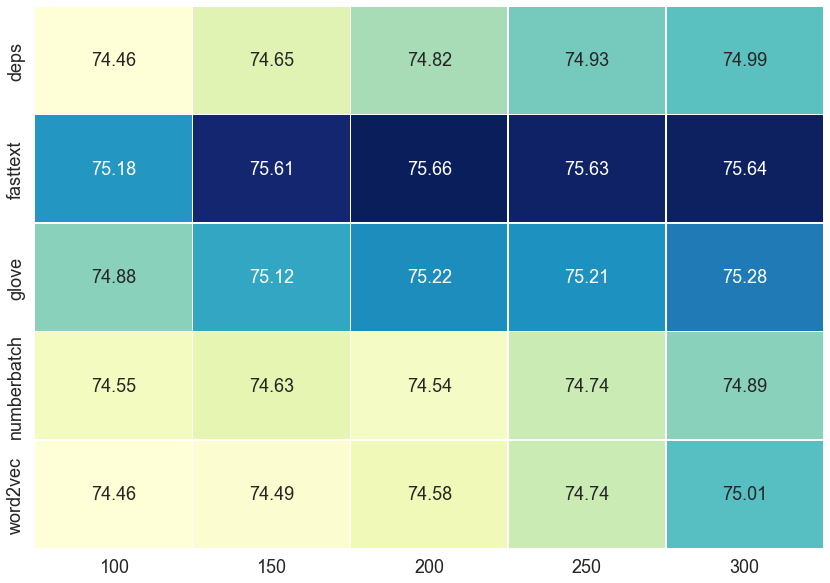

In [28]:
# Get only a model that show significant effect for embedding type (cnn, textcnn, dcnn, lstm)
heatmap_data = embed_acc_data[embed_acc_data['model_name'] == 'dcnn']

# Generate accuracy heatmap
heatmap_data.drop(['model_name', 'test_acc'], axis=1, inplace=True)
heatmap_data = pd.pivot_table(heatmap_data, values='val_acc', index=['embedding_type'], columns='embedding_dim')
g = plot_heatmap(heatmap_data, title='', y_label='', x_label='', colour='YlGnBu', num_colour=100, square=False,
                 show_cbar=False, annotate=True, annot_font_size=18, num_format='.2f', y_tick_rotation=90)
g.savefig(os.path.join(task_name, 'embedding_type', 'embedding_type_dcnn_accuracy.png'))

Pairwise Bayes sign rank

In [ ]:
# # Set the metric to test
# metric = 'val_acc'
#
# # Multi-pairwise Bayes takes a long time to calculate, so save/load as needed
# # embed_data['embedd_val'] = embed_data.apply(lambda  row: row['embedding_type'] + '-' + str(row['embedding_dim']), axis=1)
# # embed_bayes_frame = multi_pairwise_bayes_signrank(embed_data, 'model_name', 'embedd_val', metric, rope=0.5)
# # save_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type_bayes_results.csv'), embed_bayes_frame)
#
# embed_bayes_frame = load_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type_bayes_results.csv'))
#
# # Generate heatmaps
# embed_bayes_right = embed_bayes_frame.loc[embed_bayes_frame['right'] >= 0.8]
# g, fig = plot_facetgrid(embed_bayes_right, x='model_A', y='model_B', hue='right', col='model_name', kind='heatmap',
#                         title='P(B > A)', y_label='A', x_label='B', num_col=2, colour='RdBu_r',
#                         annot=True, fmt='0.2', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.8, 1.0],
#                         x_tick_rotation=45, y_tick_rotation=45, height=6)
# fig.show()
#
# embed_bayes_left = embed_bayes_frame.loc[embed_bayes_frame['left'] >= 0.8]
# g, fig = plot_facetgrid(embed_bayes_left, x='model_A', y='model_B', hue='left', col='model_name', kind='heatmap',
#                         title='P(A > B)', y_label='A', x_label='B', num_col=2, colour='RdBu_r',
#                         annot=True, fmt='0.2', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.8, 1.0],
#                         x_tick_rotation=45, y_tick_rotation=45, height=6)
# fig.show()
# embed_bayes_frame.round(3)

Embedding dim only

In [121]:
# Set the metric to test
metric = 'val_acc'

# Multi-pairwise Bayes takes a long time to calculate, so save/load as needed
# embed_dim_bayes_frame = pd.DataFrame()
# # Get each embedding type for each model
# for model_name in embed_data['model_name'].unique():
#     for embed_type in embed_data['embedding_type'].unique():
#         type_data = embed_data.loc[(embed_data['model_name'] == model_name) & (embed_data['embedding_type'] == embed_type)]
#         # Run Bayes only comparing the dimension for that type
#         cur_bayes = pairwise_bayes_signrank(type_data, 'embedding_dim', metric, rope=0.5)
#         cur_bayes.insert(0, 'model_name', model_name)
#         cur_bayes.insert(1, 'embed_type', embed_type)
#         embed_dim_bayes_frame = pd.concat([embed_dim_bayes_frame, cur_bayes], axis=0)
# save_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_dim-only_bayes_results.csv'), embed_dim_bayes_frame)

embed_dim_bayes_frame = load_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_dim-only_bayes_results.csv'))
embed_dim_bayes_frame.drop('index', axis=1, inplace=True)


# Show only where there are significant results
embed_dim_bayes_frame = embed_dim_bayes_frame.loc[(embed_dim_bayes_frame['left'] >= 0.8) | (embed_dim_bayes_frame['right'] >= 0.8)]
embed_dim_bayes_frame.round(3)

,model_name,embed_type,model_A,model_B,P({a} > {b}),P({a} == {b}),P({b} > {a}),left,within,right
230,lstm,word2vec,100,250,0.0,0.184,0.816,0.0,0.184,0.816


Embedding type only


In [133]:
# Set the metric to test
metric = 'val_acc'

# Multi-pairwise Bayes takes a long time to calculate, so save/load as needed
# embed_type_bayes_frame = multi_pairwise_bayes_signrank(embed_data, 'model_name', 'embedding_type', metric, rope=0.5)
# save_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type-only_bayes_results.csv'), embed_type_bayes_frame)

embed_type_bayes_frame = load_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type-only_bayes_results.csv'))
embed_type_bayes_frame.drop('index', axis=1, inplace=True)

# Show only where there are significant results
embed_type_bayes_frame = embed_type_bayes_frame.loc[(embed_type_bayes_frame['left'] >= 0.8) | (embed_type_bayes_frame['right'] >= 0.8)]
embed_type_bayes_frame.round(3)

,model_name,model_A,model_B,P({a} > {b}),P({a} == {b}),P({b} > {a}),left,within,right
20,dcnn,fasttext,deps,1.0,0.0,0.0,1.0,0.0,0.0
21,dcnn,fasttext,numberbatch,1.0,0.0,0.0,1.0,0.0,0.0
22,dcnn,fasttext,word2vec,1.0,0.0,0.0,1.0,0.0,0.0


# Input sequence and embeddings final results

Results for the 6 base models using the parameters (vocabulary size, sequence length and embeddings) from previous experiments.

In [2]:
# Name of the experiment parameter for comparison
exp_param = 'input_seq_final'

# Load language models experiment data
inseq_final_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
inseq_final_mean_data = load_dataframe(os.path.join(task_name,  exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(inseq_final_mean_data.loc[[inseq_final_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(inseq_final_mean_data.loc[[inseq_final_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
inseq_final_data_max = get_max(inseq_final_mean_data, [])
inseq_final_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
  model_name    val_acc  val_acc_std
1   text cnn  75.825126     0.210506
Best test accuracy in mean data:
  model_name   test_acc  test_acc_std  f1_weighted  f1_weighted_std
1   text cnn  73.362165       0.34404     0.709663         0.005089


,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,74.70,0.16,71.16,0.64,0.6818,0.0087
1,text cnn,75.83,0.21,73.36,0.34,0.7097,0.0051
2,dcnn,75.78,0.22,72.87,0.53,0.7057,0.0063
3,rcnn,74.97,0.15,72.44,0.41,0.6900,0.0059
4,lstm,75.76,0.16,73.06,0.37,0.6994,0.0041
5,gru,74.80,0.16,72.27,0.74,0.6901,0.0100


# Model variants results

Results and comparison for the bi-directional and multi-layer for recurrent models.
Results and comparison for the attentional variants of all 6 base models.

In [3]:
# Name of the experiment parameter for comparison
exp_param = 'model_variants'
metric = 'val_acc'

# Load language models experiment data
variants_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
variants_mean_data = load_dataframe(os.path.join(task_name,  exp_param, exp_param + '_mean_data.csv'))

# Remove CRF because they are strictly worse
variants_data = variants_data[~variants_data['model_name'].str.contains('crf')]
variants_mean_data = variants_mean_data[~variants_mean_data['model_name'].str.contains('crf')]

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(variants_mean_data.loc[[variants_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(variants_mean_data.loc[[variants_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
variants_data_max = get_max(variants_mean_data, [])
variants_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
       model_name    val_acc  val_acc_std
13  text cnn attn  75.706358     0.156832
Best test accuracy in mean data:
       model_name   test_acc  test_acc_std  f1_weighted  f1_weighted_std
13  text cnn attn  73.445173       0.36633     0.711044         0.005255


,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,bi gru,74.35,0.26,72.34,0.28,0.6906,0.0048
1,bi lstm,74.94,0.20,72.26,0.78,0.6883,0.0123
2,cnn attn,74.91,0.30,72.14,0.70,0.6936,0.0086
3,dcnn attn,75.01,0.22,72.19,0.30,0.6981,0.0035
4,deep gru 2lyr,75.32,0.18,72.78,0.37,0.6968,0.0043
5,deep gru 3lyr,75.09,0.19,72.43,0.58,0.6917,0.0077
6,deep lstm 2lyr,75.40,0.14,73.28,0.54,0.7012,0.0064
7,deep lstm 3lyr,75.37,0.20,73.26,0.44,0.7018,0.0051
8,gru attn,74.99,0.20,72.51,0.30,0.6925,0.0043
9,lstm attn,75.67,0.11,72.85,0.59,0.6957,0.0075


Merge base and variant results

In [4]:
# Merge all of the supervised models results
final_data = pd.concat([inseq_final_data, variants_data], ignore_index=True)
final_data.drop('index', axis=1, inplace=True)

final_mean_data = pd.concat([inseq_final_mean_data, variants_mean_data], ignore_index=True)
final_mean_data.drop('index', axis=1, inplace=True)
final_mean_data = final_mean_data.drop(final_mean_data.columns.difference(['model_name', 'val_acc', 'val_acc_std',
                                                                           'test_acc', 'test_acc_std', 'f1_weighted',
                                                                           'f1_weighted_std']), axis=1)

### Multi-layer

Test assumptions using Shapiro-Wilks test for normality and Mauchly test for sphericity.
Run RM ANOVA between recurrent models and their multi layer (2 and 3 layers) variants.

In [5]:
# Get only the recurrent models and variants
deep_lstm_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|bi')]
deep_lstm_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|bi')]

deep_gru_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|bi')]
deep_gru_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|bi')]

# Show multi-layer results
deep_recurrent_data = pd.concat([deep_lstm_mean_data, deep_gru_mean_data], ignore_index=True)
deep_recurrent_data = deep_recurrent_data[['model_name', 'val_acc', 'val_acc_std','test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']]
deep_recurrent_data.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,lstm,75.76,0.16,73.06,0.37,0.6994,0.0041
1,deep lstm 2lyr,75.40,0.14,73.28,0.54,0.7012,0.0064
2,deep lstm 3lyr,75.37,0.20,73.26,0.44,0.7018,0.0051
3,gru,74.80,0.16,72.27,0.74,0.6901,0.0100
4,deep gru 2lyr,75.32,0.18,72.78,0.37,0.6968,0.0043
5,deep gru 3lyr,75.09,0.19,72.43,0.58,0.6917,0.0077


In [6]:
print("#### LSTM Multi-layer Variants ####")

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(deep_lstm_data, 'model_name', metric)

# Run ANOVA
deep_lstm_anova = rm_one_way_anova_test(deep_lstm_data, 'model_name', metric, sig_level=alpha)
print(deep_lstm_anova)

# Run Tukey-HSD post-hoc analysis
tukey_hsd(deep_lstm_data, 'model_name', metric)

# Run pairwise bayes sign-rank
print("Bayes sign-rank:")
_ = pairwise_bayes_signrank(deep_lstm_data, 'model_name', metric, rope=0.5, show_result=True)

print("#### GRU Multi-layer Variants ####")

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(deep_gru_data, 'model_name', metric)

# Run ANOVA
deep_gru_anova = rm_one_way_anova_test(deep_gru_data, 'model_name', metric, sig_level=alpha)
print(deep_gru_anova)

# Run Tukey-HSD post-hoc analysis
tukey_hsd(deep_gru_data, 'model_name', metric)

# Run pairwise bayes sign-rank
print("Bayes sign-rank:")
_ = pairwise_bayes_signrank(deep_gru_data, 'model_name', metric, rope=0.5, show_result=True)

#### LSTM Multi-layer Variants ####
All models model_name are normally distributed.
The models have significant p-values when comparing groups. P-value = 0.00033
       Source        SS  DF        MS          F     p-unc  p-GG-corr       np2       eps sphericity   W-spher   p-spher   cohen_f   n     exp_n    power  exp_power
0  model_name  0.935216   2  0.467608  14.397586  0.000184   0.000331  0.615345  0.905799       True  0.896002  0.644519  1.116132  30  12.18592  0.99917        0.8
1       Error  0.584608  18  0.032478        NaN       NaN        NaN       NaN       NaN        NaN       NaN       NaN  1.116132  30  12.18592  0.99917        0.8
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj  lower  upper  reject
------------------------------------------------------------------
deep lstm 2lyr deep lstm 3lyr  -0.0302   0.9 -0.2155  0.155  False
deep lstm 2lyr           lstm   0.3585 0.001  0.1732 0.5438   True
deep lst

### Bi-directional

In [7]:
# Get only base and bi-directional models
bi_lstm_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|deep')]
bi_lstm_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|deep')]

bi_gru_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|deep')]
bi_gru_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|deep')]

# Show bi-directional results
bi_directional_data = pd.concat([bi_lstm_mean_data, bi_gru_mean_data], ignore_index=True)
bi_directional_data = bi_directional_data[['model_name', 'val_acc', 'val_acc_std','test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']]
bi_directional_data.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,lstm,75.76,0.16,73.06,0.37,0.6994,0.0041
1,bi lstm,74.94,0.20,72.26,0.78,0.6883,0.0123
2,gru,74.80,0.16,72.27,0.74,0.6901,0.0100
3,bi gru,74.35,0.26,72.34,0.28,0.6906,0.0048


Run Wilcoxon and Bayes sign rank test comparing base recurrent models and their bi-directional variants.

In [8]:
print("#### LSTM Bi-directional Variants ####")

# Select the data to compare
data_a = bi_lstm_data.loc[(bi_lstm_data['model_name'] == 'lstm')][metric]
data_b = bi_lstm_data.loc[(bi_lstm_data['model_name'] == 'bi lstm')][metric]

# Wilcoxon test (with continuity correction)
stats = pg.wilcoxon(data_a, data_b).to_dict(orient='records')[0]
power = pg.power_chi2(dof=1, w=stats['RBC'], n=20, alpha=alpha)
exp_n = int(pg.power_chi2(dof=1, w=stats['RBC'], power=power, alpha=alpha))

print("w-stat = " + str(round(stats['W-val'], 5)) + " p-value = " + str(round(stats['p-val'], 5)) +
      ' n = ' + str(exp_n) + ' power = ' + str(round(power, 5)))

# Bayes sign-rank test
_ = bayes_signrank(data_a.tolist(), data_b.tolist(), 'lstm', 'bi lstm', rope=0.5, show_result=True)

print("#### GRU Bi-directional Variants ####")

# Select the data to compare
data_a = bi_gru_data.loc[(bi_gru_data['model_name'] == 'gru')][metric]
data_b = bi_gru_data.loc[(bi_gru_data['model_name'] == 'bi gru')][metric]

# Wilcoxon test (with continuity correction)
stats = pg.wilcoxon(data_a, data_b).to_dict(orient='records')[0]
power = pg.power_chi2(dof=1, w=stats['RBC'], n=20, alpha=alpha)
exp_n = int(pg.power_chi2(dof=1, w=stats['RBC'], power=power, alpha=alpha))

print("w-stat = " + str(round(stats['W-val'], 5)) + " p-value = " + str(round(stats['p-val'], 5)) +
      ' n = ' + str(exp_n) + ' power = ' + str(round(power, 5)))

# Bayes sign-rank test
_ = bayes_signrank(data_a.tolist(), data_b.tolist(), 'gru', 'bi gru', rope=0.5, show_result=True)

#### LSTM Bi-directional Variants ####
w-stat = 0.0 p-value = 0.00592 n = 20 power = 0.994
P(lstm > bi lstm) = 0.99184, P(lstm == bi lstm) = 0.00816, P(bi lstm > lstm) = 0.0
#### GRU Bi-directional Variants ####
w-stat = 1.0 p-value = 0.00805 n = 20 power = 0.9906
P(gru > bi gru) = 0.99994, P(gru == bi gru) = 0.0, P(bi gru > gru) = 6e-05


### Attention

In [9]:
# Get only base and attentional models
attn_data = final_data[~final_data.model_name.str.contains('bi|deep|crf')]
attn_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('bi|deep|crf')]

# Show attentional results
attn_mean_data = attn_mean_data[['model_name', 'val_acc', 'val_acc_std','test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']]
attn_mean_data.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,74.70,0.16,71.16,0.64,0.6818,0.0087
1,text cnn,75.83,0.21,73.36,0.34,0.7097,0.0051
2,dcnn,75.78,0.22,72.87,0.53,0.7057,0.0063
3,rcnn,74.97,0.15,72.44,0.41,0.6900,0.0059
4,lstm,75.76,0.16,73.06,0.37,0.6994,0.0041
5,gru,74.80,0.16,72.27,0.74,0.6901,0.0100
8,cnn attn,74.91,0.30,72.14,0.70,0.6936,0.0086
9,dcnn attn,75.01,0.22,72.19,0.30,0.6981,0.0035
14,gru attn,74.99,0.20,72.51,0.30,0.6925,0.0043
15,lstm attn,75.67,0.11,72.85,0.59,0.6957,0.0075


Run Wilcoxon sign rank test comparing base models and their attentional variants.

In [37]:
# Create results frame
wilcox_test_frame = pd.DataFrame(columns=['model_name', 'p-value'])

# Perform wilcoxon for each model and its attn variant
for model in ['cnn', 'text cnn', 'dcnn', 'rcnn', 'lstm', 'gru']:

    current_attn_data = attn_data.loc[(attn_data['model_name'] == model) | (attn_data['model_name'] == model + ' attn')]

    # Select the data to compare
    data_a = attn_data.loc[(attn_data['model_name'] == model)][metric]
    data_b = attn_data.loc[(attn_data['model_name'] == model + ' attn')][metric]

    # Wilcoxon test (with continuity correction)
    stats = pg.wilcoxon(data_a, data_b).to_dict(orient='records')[0]
    power = pg.power_chi2(dof=1, w=stats['RBC'], n=20, alpha=alpha)
    exp_n = int(pg.power_chi2(dof=1, w=stats['RBC'], power=power, alpha=alpha))

    # Append to result frame
    wilcox_test_frame = wilcox_test_frame.append({'model_name': model, 'w-stat': stats['W-val'], 'p-value': stats['p-val'],
                                                  'effect': stats['RBC'], 'exp_n': exp_n, 'power': power, 'exp_power': 0.8},
                                                 ignore_index=True)


if all(p_value <= alpha for p_value in wilcox_test_frame['p-value']):
    print("All models have significant p-values when comparing attention groups.")
else:
    print("The following models do not have significant p-values when comparing attention groups.")
    print(wilcox_test_frame.loc[wilcox_test_frame['p-value'] > alpha])

wilcox_test_frame.round(5)

The following models do not have significant p-values when comparing attention groups.
  model_name   p-value    effect  exp_n  exp_power     power  w-stat
0        cnn  0.102918 -0.600000   20.0        0.8  0.765259    11.0
1   text cnn  0.083131  0.636364   19.0        0.8  0.812176    10.0
4       lstm  0.185144  0.490909   20.0        0.8  0.593086    14.0


,model_name,p-value,effect,exp_n,exp_power,power,w-stat
0,cnn,0.10292,-0.60000,20.0,0.8,0.76526,11.0
1,text cnn,0.08313,0.63636,19.0,0.8,0.81218,10.0
2,dcnn,0.00592,1.00000,20.0,0.8,0.99400,0.0
3,rcnn,0.01906,0.85455,20.0,0.8,0.96868,4.0
4,lstm,0.18514,0.49091,20.0,0.8,0.59309,14.0
5,gru,0.03231,-0.78182,20.0,0.8,0.93778,6.0


Run Bayes sign-rank

In [10]:
for model_name in ['cnn', 'text cnn', 'dcnn', 'rcnn', 'lstm', 'gru']:
    # Get current model data to lists
    current_attn_data = attn_data.loc[(attn_data['model_name'] == model_name) | (attn_data['model_name'] == model_name + ' attn')]

    # Select the data to compare
    no_attn = attn_data.loc[(attn_data['model_name'] == model_name)]['val_acc'].tolist()
    attn = attn_data.loc[(attn_data['model_name'] == model_name + ' attn')]['val_acc'].tolist()

    # Pair data into 2d array
    curr_data = pair_data(no_attn, attn)

    # Apply Bayesian sign rank
    left, within, right = bt.signrank(curr_data, rope=0.5, verbose=False)
    print('Model: {m1} P({c1} > {c2}) = {pl}, P(rope) = {pe}, P({c2} > {c1}) = {pr}'.
          format(m1=model_name, c1='no_attn', c2='attn', pl=left, pe=within, pr=right))

Model: cnn P(no_attn > attn) = 0.0, P(rope) = 0.99426, P(attn > no_attn) = 0.00574
Model: text cnn P(no_attn > attn) = 8e-05, P(rope) = 0.99992, P(attn > no_attn) = 0.0
Model: dcnn P(no_attn > attn) = 0.98942, P(rope) = 0.01058, P(attn > no_attn) = 0.0
Model: rcnn P(no_attn > attn) = 0.01122, P(rope) = 0.98878, P(attn > no_attn) = 0.0
Model: lstm P(no_attn > attn) = 0.0, P(rope) = 1.0, P(attn > no_attn) = 0.0
Model: gru P(no_attn > attn) = 0.0, P(rope) = 1.0, P(attn > no_attn) = 0.0


# Language Models

Using pre-trained language models to generate sequence representations.

In [11]:
# Name of the experiment parameter for comparison
exp_param = 'embedding_type'

# Load language models experiment data
lm_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_data.csv'))
lm_mean_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
lm_data_max = get_max(lm_mean_data, [exp_param])
lm_data_max.drop('embedding_type', axis=1, inplace=True)
lm_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
  model_name    val_acc  val_acc_std
1    roberta  78.166262     0.333614
Best test accuracy in mean data:
  model_name  test_acc  test_acc_std  f1_weighted  f1_weighted_std
1    roberta  76.21721      0.555866     0.736829         0.007001


,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,bert,76.87,0.24,76.07,0.42,0.7381,0.0053
1,roberta,78.17,0.33,76.22,0.56,0.7368,0.0070
2,gpt2,77.47,0.44,75.16,0.62,0.7267,0.0060
3,dialogpt,77.82,0.44,75.30,0.37,0.7280,0.0037
4,xlnet,78.15,0.46,75.88,0.45,0.7344,0.0069
5,convert,76.54,0.22,74.31,0.34,0.7189,0.0048
6,elmo,76.00,0.20,73.19,0.53,0.7095,0.0052
7,use,76.20,0.15,73.51,0.38,0.7124,0.0046
8,mlstm char lm,75.78,0.25,73.48,0.61,0.7117,0.0079
9,nnlm,73.44,0.07,70.12,0.26,0.6726,0.0030


Plot accuracy of each language model.

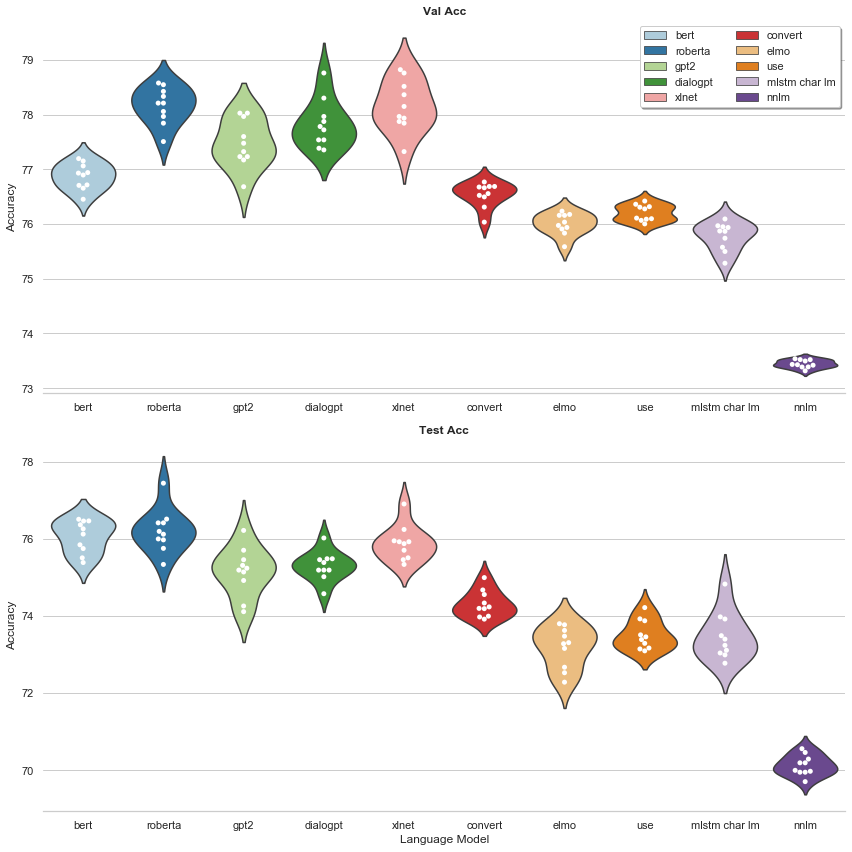

In [40]:
# Get test and validation accuracy for each model
lm_acc_data = lm_data.drop(lm_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
lm_acc_data = lm_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
lm_acc_data = lm_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(lm_acc_data, x="model_name", y="value", hue="model_name", col='variable', kind='swarm_violin',
                        num_legend_col=2, y_label='Accuracy', x_label='Language Model',
                        share_y=False, num_col=1, colour='Paired', dodge=False)
g.savefig(os.path.join(task_name, 'language_models', 'language_models' + '_accuracy.png'))

Run Wilcoxon sign rank test to compare each language models with the best supervised model.

In [41]:
# Set the metric to test
metric = 'test_acc'

# Create results frame
wilcox_lm_test_frame = pd.DataFrame(columns=['model_name', 'p-value'])

# Perform t-test for each model and its attn variant
for model_name in (lm_data['model_name'].unique()):

    # Select the data to compare
    data_a = lm_data.loc[(lm_data['model_name'] == model_name)][metric]
    data_b = final_data.loc[(final_data['model_name'] == 'text cnn')][metric]

    # Wilcoxon test (with continuity correction)
    stats = pg.wilcoxon(data_a, data_b).to_dict(orient='records')[0]
    power = pg.power_chi2(dof=1, w=stats['RBC'], n=20, alpha=alpha)
    exp_n = int(pg.power_chi2(dof=1, w=stats['RBC'], power=power, alpha=alpha))

    # Append to result frame
    wilcox_lm_test_frame = wilcox_lm_test_frame.append({'model_name': model_name, 'w-stat': stats['W-val'], 'p-value': stats['p-val'],
                                                  'effect': stats['RBC'], 'exp_n': exp_n, 'power': power, 'exp_power': 0.8},
                                                 ignore_index=True)


if all(p_value <= alpha for p_value in wilcox_lm_test_frame['p-value']):
    print("All models have significant p-values when comparing best lm and supervised groups.")
else:
    print("The following models do not have significant p-values when comparing best lm and supervised groups.")
    print(wilcox_lm_test_frame.loc[wilcox_lm_test_frame['p-value'] > alpha])

wilcox_lm_test_frame.round(5)

The following models do not have significant p-values when comparing best lm and supervised groups.
      model_name   p-value    effect  exp_n  exp_power     power  w-stat
6           elmo  0.221272 -0.454545   19.0        0.8  0.529060    15.0
7            use  0.262193  0.418182   20.0        0.8  0.464288    16.0
8  mlstm char lm  1.000000 -0.018182   20.0        0.8  0.050758    27.0


,model_name,p-value,effect,exp_n,exp_power,power,w-stat
0,bert,0.00592,1.00000,20.0,0.8,0.99400,0.0
1,roberta,0.00592,1.00000,20.0,0.8,0.99400,0.0
2,gpt2,0.00592,1.00000,20.0,0.8,0.99400,0.0
3,dialogpt,0.00592,1.00000,20.0,0.8,0.99400,0.0
4,xlnet,0.00592,1.00000,20.0,0.8,0.99400,0.0
5,convert,0.00592,1.00000,20.0,0.8,0.99400,0.0
6,elmo,0.22127,-0.45455,19.0,0.8,0.52906,15.0
7,use,0.26219,0.41818,20.0,0.8,0.46429,16.0
8,mlstm char lm,1.00000,-0.01818,20.0,0.8,0.05076,27.0
9,nnlm,0.00592,-1.00000,20.0,0.8,0.99400,0.0


Run Bayes sign-rank

In [12]:
# Perform t-test for each model and its attn variant
for model_name in (lm_data['model_name'].unique()):

    # Select the data to compare
    data_a = lm_data.loc[(lm_data['model_name'] == model_name)][metric].tolist()
    data_b = final_data.loc[(final_data['model_name'] == 'text cnn')][metric].tolist()

    # Pair data into 2d array
    curr_data = pair_data(data_a, data_b)

    # Apply Baysian sign rank
    left, within, right = bt.signrank(curr_data, rope=0.5, verbose=False)
    print('Model: {m1} P({c1} > {c2}) = {pl}, P(rope) = {pe}, P({c2} > {c1}) = {pr}'.
          format(m1=model_name, c1=model_name, c2='text cnn', pl=left, pe=within, pr=right))

Model: bert P(bert > text cnn) = 0.99942, P(rope) = 0.00058, P(text cnn > bert) = 0.0
Model: roberta P(roberta > text cnn) = 1.0, P(rope) = 0.0, P(text cnn > roberta) = 0.0
Model: gpt2 P(gpt2 > text cnn) = 1.0, P(rope) = 0.0, P(text cnn > gpt2) = 0.0
Model: dialogpt P(dialogpt > text cnn) = 1.0, P(rope) = 0.0, P(text cnn > dialogpt) = 0.0
Model: xlnet P(xlnet > text cnn) = 1.0, P(rope) = 0.0, P(text cnn > xlnet) = 0.0
Model: convert P(convert > text cnn) = 0.9833, P(rope) = 0.0167, P(text cnn > convert) = 0.0
Model: elmo P(elmo > text cnn) = 0.0002, P(rope) = 0.9998, P(text cnn > elmo) = 0.0
Model: use P(use > text cnn) = 0.08942, P(rope) = 0.91058, P(text cnn > use) = 0.0
Model: mlstm char lm P(mlstm char lm > text cnn) = 0.0, P(rope) = 1.0, P(text cnn > mlstm char lm) = 0.0
Model: nnlm P(nnlm > text cnn) = 0.0, P(rope) = 0.0, P(text cnn > nnlm) = 1.0
